# Does a 5 layer neural network on the data in cleaned_spotify.csv

In [ ]:
%pip install pandas numpy lightning scikit-learn torchmetrics matplotlib optuna

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 54.0 MB/s eta 0:00:00
Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.4 MB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# imports
import os
os.environ['PJRT_DEVICE'] = "GPU"
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from typing import cast, List
from sklearn.decomposition import PCA
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import torchmetrics as tm
import optuna
import plotly
import plotly.express as px

# Model

The model predicts track genre with respect to all other variables except for numeric ones, album name, and track name.

We made sure to one-hot encode the track genre and standardize and mean-center the data.

The model is a 3 layer neural network with 1 hidden layer. The hidden layer size and learning rate are kept as variable hyperparameters, with defaults being 0.001 and 32 (and optimimums 0.005 and 91). The hidden layer uses the ReLU activation function and the output layer uses softmax, as the output is a one-hot encoded mutli-class classification.

The model is trained using the cross entropy loss function using mini-batched gradient descent of batch size 32. It uses the pytorch lightning package for acceleration and optimization, which handles backpropagation. 

The model is assessed by cross entropy, and accuracy is reported as a more human-readable metric. 

# Data loading and feature selection

In [ ]:
# Load the cleaned data
data = pd.read_csv('csv_outputs/cleaned_spotify.csv')

# Split the data into training and testing sets
prediction = 'track_genre'
categorical_columns = ['track_name', 'artists', 'album_name', 'track_name']
X = data.drop(columns=[prediction, 'track_id', *categorical_columns])
y = data[prediction]

# one hot encode the y values
y = pd.get_dummies(y)

# Normalize the data
X = (X - X.mean()) / X.std()

In [80]:
# split into train and test
X_split, X_test, y_split, y_test = cast(
    List[pd.DataFrame],
    train_test_split(X, y, test_size=0.2, random_state=42)
)

X_train, X_val, y_train, y_val = cast(
    List[pd.DataFrame],train_test_split(
        X_split, y_split,
        test_size=0.25,
        random_state=42
    )
)

# Convert the data to tensors
X_train = torch.tensor(X_train.to_numpy(np.float32), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(np.float32), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(np.float32), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(np.float32), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(np.float32), dtype=torch.float32)

In [76]:
# Create a PyTorch dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Create a PyTorch dataloader (to enabled batch training)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model
class Model(pl.LightningModule):
    def __init__(
            self,
            # hyperparameters
            lr = 0.001,
            hidden_size = 32
        ):
        super(Model, self).__init__()
        # the actual model
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, y_train.shape[1]),
            nn.Softmax(dim=1), # For multi-class classification
        )
        self.learning_rate = lr
        self.epoch_metrics = dict()

    def forward(self, x):
        return self.model(x)

    # training loss function (for backpropagation)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        y_hat = self(X_test)

        with torch.no_grad():
            cross_entropy = F.cross_entropy(y_hat, y_test.argmax(dim=1))
            accuracy = tm.Accuracy(task="multiclass", num_classes=y_test.shape[1])(y_hat, y_test.argmax(dim=1))
            self.epoch_metrics[self.current_epoch] = dict(
                cross_entropy=cross_entropy,
                accuracy=accuracy
            )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [84]:
# Hyperparameters, learned from below
lr = 0.005
hidden_size = 91

# Train the model
model = Model(lr, hidden_size)
model.train()

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    default_root_dir="w10checkpoints/",
    accumulate_grad_batches=7
)

ckpt_path=None
# ckpt_path="./w10checkpoints/lightning_logs/version_15/checkpoints/epoch=9-step=4080.ckpt"
trainer.fit(model, train_dataloader, val_dataloader, ckpt_path=ckpt_path)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.9 K | train
---------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 448.98it/s, v_num=95, val_loss=4.520]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 448.72it/s, v_num=95, val_loss=4.520]


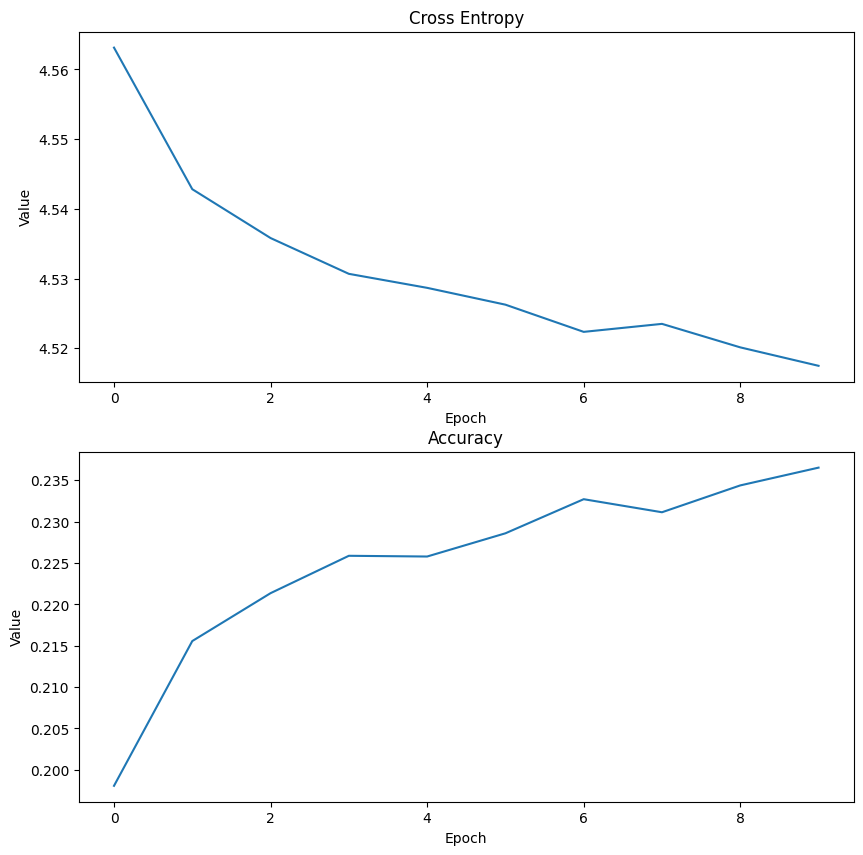

In [82]:
# graph the epoch metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot([m['cross_entropy'] for m in model.epoch_metrics.values()])
ax[0].set_title('Cross Entropy')
ax[1].plot([m['accuracy'] for m in model.epoch_metrics.values()])
ax[1].set_title('Accuracy')
# axes labels
for a in ax:
    a.set_xlabel('Epoch')
    a.set_ylabel('Value')

None


# Learning Hyperparameters
To learn hyperparameters, we trained the model using various hyperparameters (using the optuna library) and chose the one that created lowest loss.

In [72]:
# Choosing hyperparameters
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True)
    hidden_size = trial.suggest_int('hidden_size', 8, 128, log=True)

    model = Model(learning_rate, hidden_size)

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='cpu',
        default_root_dir="w10checkpoints/",
        accumulate_grad_batches=7
    )

    trainer.fit(model, train_dataloader, val_dataloader)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Optimum hyperparameters: ", study.best_params["learning_rate"])

[I 2024-12-06 02:15:36,917] A new study created in memory with name: no-name-6871b2a0-15ea-4dc2-9153-93878907f31a
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.5 K  | train
---------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 460.14it/s, v_num=42, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 459.89it/s, v_num=42, val_loss=4.740]


[I 2024-12-06 02:16:23,763] Trial 0 finished with value: 4.7362775802612305 and parameters: {'learning_rate': 1.1907784683400686e-06, 'hidden_size': 27}. Best is trial 0 with value: 4.7362775802612305.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 5.4 K  | train
---------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 463.62it/s, v_num=43, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 463.36it/s, v_num=43, val_loss=4.740]


[I 2024-12-06 02:17:10,664] Trial 1 finished with value: 4.736181735992432 and parameters: {'learning_rate': 2.0218848961408936e-08, 'hidden_size': 42}. Best is trial 1 with value: 4.736181735992432.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 10.9 K | train
---------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.043     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 452.46it/s, v_num=44, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 452.21it/s, v_num=44, val_loss=4.740]


[I 2024-12-06 02:17:57,881] Trial 2 finished with value: 4.735747337341309 and parameters: {'learning_rate': 2.7385282012153355e-06, 'hidden_size': 86}. Best is trial 2 with value: 4.735747337341309.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.1 K  | train
---------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.07it/s, v_num=45, val_loss=4.700]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.85it/s, v_num=45, val_loss=4.700]


[I 2024-12-06 02:18:44,779] Trial 3 finished with value: 4.6984639167785645 and parameters: {'learning_rate': 0.00021976463234769217, 'hidden_size': 8}. Best is trial 3 with value: 4.6984639167785645.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 4.4 K  | train
---------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 450.59it/s, v_num=46, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 450.34it/s, v_num=46, val_loss=4.740]


[I 2024-12-06 02:19:32,120] Trial 4 finished with value: 4.736239910125732 and parameters: {'learning_rate': 1.0705901845895149e-07, 'hidden_size': 34}. Best is trial 3 with value: 4.6984639167785645.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.5 K  | train
---------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.57it/s, v_num=47, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.34it/s, v_num=47, val_loss=4.740]


[I 2024-12-06 02:20:20,318] Trial 5 finished with value: 4.736301898956299 and parameters: {'learning_rate': 2.671349832013953e-07, 'hidden_size': 19}. Best is trial 3 with value: 4.6984639167785645.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 4.4 K  | train
---------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 464.97it/s, v_num=48, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 464.71it/s, v_num=48, val_loss=4.740]


[I 2024-12-06 02:21:06,615] Trial 6 finished with value: 4.735495567321777 and parameters: {'learning_rate': 1.0104453726707835e-05, 'hidden_size': 34}. Best is trial 3 with value: 4.6984639167785645.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 12.5 K | train
---------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.55it/s, v_num=49, val_loss=4.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.28it/s, v_num=49, val_loss=4.590]


[I 2024-12-06 02:21:53,394] Trial 7 finished with value: 4.59010648727417 and parameters: {'learning_rate': 0.00042499122292804223, 'hidden_size': 99}. Best is trial 7 with value: 4.59010648727417.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.5 K  | train
---------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 465.57it/s, v_num=50, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 465.32it/s, v_num=50, val_loss=4.740]


[I 2024-12-06 02:22:39,562] Trial 8 finished with value: 4.736293792724609 and parameters: {'learning_rate': 5.985582717457805e-07, 'hidden_size': 19}. Best is trial 7 with value: 4.59010648727417.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.5 K  | train
---------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 463.64it/s, v_num=51, val_loss=4.710]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 463.40it/s, v_num=51, val_loss=4.710]


[I 2024-12-06 02:23:25,829] Trial 9 finished with value: 4.70996618270874 and parameters: {'learning_rate': 9.740211284521172e-05, 'hidden_size': 19}. Best is trial 7 with value: 4.59010648727417.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 12.2 K | train
---------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 461.24it/s, v_num=52, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 460.98it/s, v_num=52, val_loss=4.560]

[I 2024-12-06 02:24:12,595] Trial 10 finished with value: 4.556264400482178 and parameters: {'learning_rate': 0.00459733679063834, 'hidden_size': 97}. Best is trial 10 with value: 4.556264400482178.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 15.0 K | train
---------------------------------------------
15.0 K    Trainable params
0         Non-trainable params
15.0 K    Total params
0.060     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.05it/s, v_num=53, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.82it/s, v_num=53, val_loss=4.560]


[I 2024-12-06 02:24:59,518] Trial 11 finished with value: 4.557418346405029 and parameters: {'learning_rate': 0.0066225746855126276, 'hidden_size': 119}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 15.9 K | train
---------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.063     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 455.75it/s, v_num=54, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 455.45it/s, v_num=54, val_loss=4.570]


[I 2024-12-06 02:25:46,433] Trial 12 finished with value: 4.5650811195373535 and parameters: {'learning_rate': 0.005816886962799358, 'hidden_size': 126}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.2 K  | train
---------------------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.11it/s, v_num=55, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.87it/s, v_num=55, val_loss=4.560]


[I 2024-12-06 02:26:33,136] Trial 13 finished with value: 4.5575737953186035 and parameters: {'learning_rate': 0.006613025625634917, 'hidden_size': 65}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 7.7 K  | train
---------------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 464.39it/s, v_num=56, val_loss=4.580]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 464.15it/s, v_num=56, val_loss=4.580]

[I 2024-12-06 02:27:19,544] Trial 14 finished with value: 4.577023983001709 and parameters: {'learning_rate': 0.0013091326689800753, 'hidden_size': 61}. Best is trial 10 with value: 4.556264400482178.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 15.2 K | train
---------------------------------------------
15.2 K    Trainable params
0         Non-trainable params
15.2 K    Total params
0.061     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.11it/s, v_num=57, val_loss=4.690]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.85it/s, v_num=57, val_loss=4.690]


[I 2024-12-06 02:28:06,280] Trial 15 finished with value: 4.69266939163208 and parameters: {'learning_rate': 3.9636041713041446e-05, 'hidden_size': 121}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.4 K  | train
---------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.033     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 460.55it/s, v_num=58, val_loss=4.580]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 460.30it/s, v_num=58, val_loss=4.580]


[I 2024-12-06 02:28:52,810] Trial 16 finished with value: 4.580032825469971 and parameters: {'learning_rate': 0.000870683931653148, 'hidden_size': 66}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.2 K  | train
---------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 462.47it/s, v_num=59, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 462.20it/s, v_num=59, val_loss=4.570]


[I 2024-12-06 02:29:39,350] Trial 17 finished with value: 4.565675735473633 and parameters: {'learning_rate': 0.0030112541328670517, 'hidden_size': 49}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 10.5 K | train
---------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.14it/s, v_num=60, val_loss=4.720]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 455.89it/s, v_num=60, val_loss=4.720]


[I 2024-12-06 02:30:26,186] Trial 18 finished with value: 4.720356464385986 and parameters: {'learning_rate': 2.4531255742319174e-05, 'hidden_size': 83}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.4 K  | train
---------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 461.29it/s, v_num=61, val_loss=4.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 461.04it/s, v_num=61, val_loss=4.590]


[I 2024-12-06 02:31:12,809] Trial 19 finished with value: 4.588531494140625 and parameters: {'learning_rate': 0.009798772724038502, 'hidden_size': 10}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 12.4 K | train
---------------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.049     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 455.20it/s, v_num=62, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.96it/s, v_num=62, val_loss=4.560]


[I 2024-12-06 02:31:59,669] Trial 20 finished with value: 4.564290523529053 and parameters: {'learning_rate': 0.0014419983603457308, 'hidden_size': 98}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.4 K  | train
---------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.033     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 446.35it/s, v_num=63, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 446.13it/s, v_num=63, val_loss=4.560]


[I 2024-12-06 02:32:47,370] Trial 21 finished with value: 4.557925701141357 and parameters: {'learning_rate': 0.007507223648382692, 'hidden_size': 66}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.6 K  | train
---------------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.038     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.68it/s, v_num=64, val_loss=4.610]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.42it/s, v_num=64, val_loss=4.610]


[I 2024-12-06 02:33:34,421] Trial 22 finished with value: 4.60892391204834 and parameters: {'learning_rate': 0.0002802899609258292, 'hidden_size': 76}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 7.0 K  | train
---------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.57it/s, v_num=65, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.32it/s, v_num=65, val_loss=4.560]


[I 2024-12-06 02:34:21,390] Trial 23 finished with value: 4.564719200134277 and parameters: {'learning_rate': 0.0027619719274086137, 'hidden_size': 55}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 13.7 K | train
---------------------------------------------
13.7 K    Trainable params
0         Non-trainable params
13.7 K    Total params
0.055     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.35it/s, v_num=66, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.10it/s, v_num=66, val_loss=4.570]


[I 2024-12-06 02:35:08,614] Trial 24 finished with value: 4.571032524108887 and parameters: {'learning_rate': 0.001005421047721394, 'hidden_size': 109}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.0 K  | train
---------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.00it/s, v_num=67, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 453.76it/s, v_num=67, val_loss=4.570]

[I 2024-12-06 02:35:55,576] Trial 25 finished with value: 4.569370269775391 and parameters: {'learning_rate': 0.00371432571458743, 'hidden_size': 47}. Best is trial 10 with value: 4.556264400482178.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.9 K  | train
---------------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.039     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.46it/s, v_num=68, val_loss=4.650]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.21it/s, v_num=68, val_loss=4.650]


[I 2024-12-06 02:36:42,495] Trial 26 finished with value: 4.652676582336426 and parameters: {'learning_rate': 0.00010416765387869845, 'hidden_size': 78}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 15.9 K | train
---------------------------------------------
15.9 K    Trainable params
0         Non-trainable params
15.9 K    Total params
0.063     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.51it/s, v_num=69, val_loss=4.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.24it/s, v_num=69, val_loss=4.590]


[I 2024-12-06 02:37:29,565] Trial 27 finished with value: 4.588076591491699 and parameters: {'learning_rate': 0.00045281561701370556, 'hidden_size': 126}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 10.4 K | train
---------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.041     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.19it/s, v_num=70, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 453.96it/s, v_num=70, val_loss=4.570]


[I 2024-12-06 02:38:16,505] Trial 28 finished with value: 4.566028118133545 and parameters: {'learning_rate': 0.009734286871913892, 'hidden_size': 82}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.6 K  | train
---------------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.37it/s, v_num=71, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.10it/s, v_num=71, val_loss=4.740]


[I 2024-12-06 02:39:03,194] Trial 29 finished with value: 4.736065864562988 and parameters: {'learning_rate': 2.3020975142057985e-06, 'hidden_size': 28}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 5.1 K  | train
---------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.37it/s, v_num=72, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 456.12it/s, v_num=72, val_loss=4.560]


[I 2024-12-06 02:39:49,923] Trial 30 finished with value: 4.561483383178711 and parameters: {'learning_rate': 0.00324231111018495, 'hidden_size': 40}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.1 K  | train
---------------------------------------------
8.1 K     Trainable params
0         Non-trainable params
8.1 K     Total params
0.032     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.38it/s, v_num=73, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 454.14it/s, v_num=73, val_loss=4.560]


[I 2024-12-06 02:40:36,830] Trial 31 finished with value: 4.558807849884033 and parameters: {'learning_rate': 0.007641372011768288, 'hidden_size': 64}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 12.4 K | train
---------------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.049     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 441.26it/s, v_num=74, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 441.03it/s, v_num=74, val_loss=4.570]

[I 2024-12-06 02:41:24,581] Trial 32 finished with value: 4.5663862228393555 and parameters: {'learning_rate': 0.0019242675981677101, 'hidden_size': 98}. Best is trial 10 with value: 4.556264400482178.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.7 K  | train
---------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 440.05it/s, v_num=75, val_loss=4.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 439.79it/s, v_num=75, val_loss=4.590]

[I 2024-12-06 02:42:13,319] Trial 33 finished with value: 4.587253093719482 and parameters: {'learning_rate': 0.0007636387205809339, 'hidden_size': 69}. Best is trial 10 with value: 4.556264400482178.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.9 K  | train
---------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.027     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 449.10it/s, v_num=76, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 448.83it/s, v_num=76, val_loss=4.560]


[I 2024-12-06 02:43:00,667] Trial 34 finished with value: 4.558750152587891 and parameters: {'learning_rate': 0.004156273878369292, 'hidden_size': 54}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.7 K | train
---------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 450.48it/s, v_num=77, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 450.26it/s, v_num=77, val_loss=4.740]


[I 2024-12-06 02:43:48,529] Trial 35 finished with value: 4.736171245574951 and parameters: {'learning_rate': 2.1807692929669267e-08, 'hidden_size': 93}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 5.1 K  | train
---------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 434.59it/s, v_num=78, val_loss=4.650]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 434.37it/s, v_num=78, val_loss=4.650]


[I 2024-12-06 02:44:36,817] Trial 36 finished with value: 4.65394401550293 and parameters: {'learning_rate': 0.00015407421789176057, 'hidden_size': 40}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 13.6 K | train
---------------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 452.43it/s, v_num=79, val_loss=4.580]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 452.18it/s, v_num=79, val_loss=4.580]


[I 2024-12-06 02:45:24,165] Trial 37 finished with value: 4.584747314453125 and parameters: {'learning_rate': 0.0005279472841299242, 'hidden_size': 108}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.2 K  | train
---------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 453.21it/s, v_num=80, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 452.95it/s, v_num=80, val_loss=4.570]


[I 2024-12-06 02:46:11,553] Trial 38 finished with value: 4.571168899536133 and parameters: {'learning_rate': 0.0018919577183902614, 'hidden_size': 73}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 7.5 K  | train
---------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
0.030     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:05<00:00, 418.47it/s, v_num=81, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:05<00:00, 418.19it/s, v_num=81, val_loss=4.560]


[I 2024-12-06 02:47:00,276] Trial 39 finished with value: 4.564967632293701 and parameters: {'learning_rate': 0.009248889216478897, 'hidden_size': 59}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.0 K | train
---------------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.97it/s, v_num=82, val_loss=4.730]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 457.73it/s, v_num=82, val_loss=4.730]


[I 2024-12-06 02:47:50,278] Trial 40 finished with value: 4.734541416168213 and parameters: {'learning_rate': 6.218638258089486e-06, 'hidden_size': 87}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.6 K  | train
---------------------------------------------
6.6 K     Trainable params
0         Non-trainable params
6.6 K     Total params
0.026     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 477.67it/s, v_num=83, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 477.42it/s, v_num=83, val_loss=4.560]


[I 2024-12-06 02:48:36,076] Trial 41 finished with value: 4.564816474914551 and parameters: {'learning_rate': 0.0037642089828102644, 'hidden_size': 52}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 13.6 K | train
---------------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 475.18it/s, v_num=84, val_loss=4.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 474.93it/s, v_num=84, val_loss=4.560]


[I 2024-12-06 02:49:21,514] Trial 42 finished with value: 4.558077335357666 and parameters: {'learning_rate': 0.005173119923238742, 'hidden_size': 108}. Best is trial 10 with value: 4.556264400482178.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 14.4 K | train
---------------------------------------------
14.4 K    Trainable params
0         Non-trainable params
14.4 K    Total params
0.057     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 461.07it/s, v_num=85, val_loss=4.550]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 460.83it/s, v_num=85, val_loss=4.550]


[I 2024-12-06 02:50:07,226] Trial 43 finished with value: 4.55464506149292 and parameters: {'learning_rate': 0.005901859143815362, 'hidden_size': 114}. Best is trial 43 with value: 4.55464506149292.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 13.6 K | train
---------------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 470.81it/s, v_num=86, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 470.55it/s, v_num=86, val_loss=4.570]

[I 2024-12-06 02:50:53,305] Trial 44 finished with value: 4.565253734588623 and parameters: {'learning_rate': 0.0016444778137080123, 'hidden_size': 108}. Best is trial 43 with value: 4.55464506149292.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.1 K  | train
---------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 466.13it/s, v_num=87, val_loss=4.650]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 465.87it/s, v_num=87, val_loss=4.650]

[I 2024-12-06 02:51:39,251] Trial 45 finished with value: 4.647356986999512 and parameters: {'learning_rate': 0.00025094522397277406, 'hidden_size': 24}. Best is trial 43 with value: 4.55464506149292.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.5 K | train
---------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 468.28it/s, v_num=88, val_loss=4.550]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 468.03it/s, v_num=88, val_loss=4.550]


[I 2024-12-06 02:52:26,002] Trial 46 finished with value: 4.551008224487305 and parameters: {'learning_rate': 0.0052227502858004605, 'hidden_size': 91}. Best is trial 46 with value: 4.551008224487305.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 14.7 K | train
---------------------------------------------
14.7 K    Trainable params
0         Non-trainable params
14.7 K    Total params
0.059     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 468.12it/s, v_num=89, val_loss=4.680]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 467.86it/s, v_num=89, val_loss=4.680]


[I 2024-12-06 02:53:13,109] Trial 47 finished with value: 4.681844234466553 and parameters: {'learning_rate': 4.991045354093012e-05, 'hidden_size': 117}. Best is trial 46 with value: 4.551008224487305.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 11.4 K | train
---------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.045     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 444.00it/s, v_num=90, val_loss=4.580]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 443.76it/s, v_num=90, val_loss=4.580]


[I 2024-12-06 02:54:00,684] Trial 48 finished with value: 4.579535484313965 and parameters: {'learning_rate': 0.0008092340293248885, 'hidden_size': 90}. Best is trial 46 with value: 4.551008224487305.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 1.6 K  | train
---------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 471.91it/s, v_num=91, val_loss=4.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2138/2138 [00:04<00:00, 471.68it/s, v_num=91, val_loss=4.590]


[I 2024-12-06 02:54:46,542] Trial 49 finished with value: 4.594636917114258 and parameters: {'learning_rate': 0.002528005517040048, 'hidden_size': 12}. Best is trial 46 with value: 4.551008224487305.


Optimum hyperparameters:  0.0052227502858004605


Optimum hyperparameters:  {'learning_rate': 0.0052227502858004605, 'hidden_size': 91}


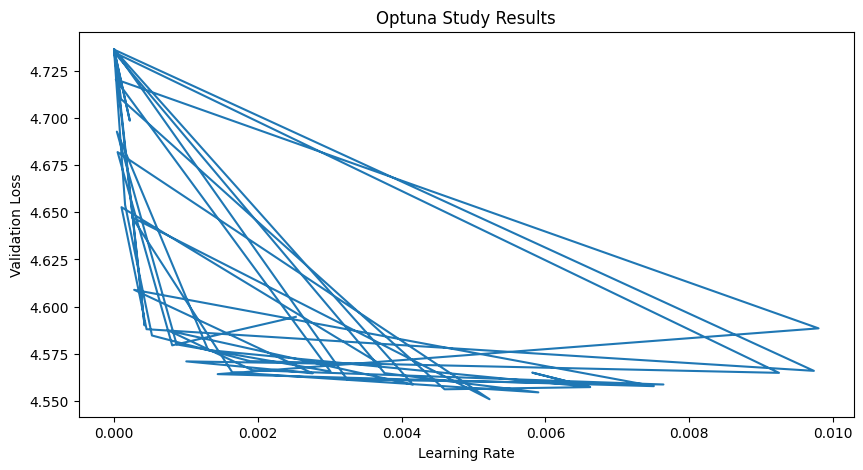

In [74]:
# plot study results by hand with x axis as parameter

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot([t.params['learning_rate'] for t in study.trials], [t.value for t in study.trials])
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_title('Optuna Study Results')

print("Optimum hyperparameters: ", study.best_params)